In [1]:
!git clone https://github.com/Ruichu-Xia/text-sharpener.git

Cloning into 'text-sharpener'...
remote: Enumerating objects: 207, done.
remote: Counting objects: 100% (207/207), done.
remote: Compressing objects: 100% (151/151), done.
remote: Total 207 (delta 123), reused 118 (delta 53), pack-reused 0 (from 0)
Receiving objects: 100% (207/207), 3.75 MiB | 8.99 MiB/s, done.
Resolving deltas: 100% (123/123), done.


In [2]:
import sys
sys.path.append('/content/text-sharpener')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import os
import json

from src.data.dataset import LocalImageDataset, get_split_indices
from src.model.BasicNet import BasicNet
from src.model.unet import UNet
from src.model.UNetV2 import UNetV2
from src.model.train import train_model, validate_model, save_checkpoint, save_samples
from src.model.utils import INPUT_DIR, TARGET_DIR, NUM_CHANNELS, NUM_EPOCHS, LEARNING_RATE, BATCH_SIZE, get_device

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [5]:
INPUT_DIR = "/content/drive/MyDrive/math156_text_sharpener/new_dataset/blurred"
TARGET_DIR = "/content/drive/MyDrive/math156_text_sharpener/new_dataset/clear"
NUM_EPOCHS = 1000
BATCH_SIZE = 128
LEARNING_RATE = 0.01

GRAD_CLIP = 1
EDGE_WEIGHT = 0.3

history = {
    "train_loss": [],
    "train_psnr": [],
    "val_loss": [],
    "val_psnr": []
}

In [ ]:
import gc
gc.collect()

# Clear PyTorch's cache
torch.cuda.empty_cache()

In [11]:
device = get_device()
# model = BasicNet(channels=NUM_CHANNELS)
model = UNetV2(in_channels=NUM_CHANNELS, out_channels=NUM_CHANNELS, features=[64, 128])
model = model.to(device)
reconstruction_loss = nn.L1Loss()

optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
scaler = torch.amp.GradScaler('cuda')
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=60)

num_images = len([f for f in os.listdir(INPUT_DIR) if f.endswith(('.jpg', '.png', '.jpeg', '.webp'))])

# load test indices
with open("/content/text-sharpener/src/model/test_indices.json", "r") as f:
    test_indices = json.load(f)

train_indices, val_indices = get_split_indices(num_images, test_indices)

train_loader = DataLoader(LocalImageDataset(INPUT_DIR, TARGET_DIR, train_indices), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(LocalImageDataset(INPUT_DIR, TARGET_DIR, val_indices), batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(LocalImageDataset(INPUT_DIR, TARGET_DIR, test_indices), batch_size=BATCH_SIZE, shuffle=True)

best_val_loss = float('inf')

save_ckpt = 100
checkpoint_dir = "/content/drive/MyDrive/math156_text_sharpener/unetv2_checkpoints_l1edge_loss"

n_samples = 5
samples_to_visualize = DataLoader(LocalImageDataset(INPUT_DIR, TARGET_DIR, val_indices), batch_size=n_samples, shuffle=False)

sample_dir = "/content/drive/MyDrive/math156_text_sharpener/unetv2_samples_l1edge_loss"

train_losses = []
val_losses = []

In [12]:
for epoch in range(1, NUM_EPOCHS + 1):
    train_loss, train_psnr = train_model(model, train_loader, optimizer, reconstruction_loss, scaler, GRAD_CLIP, EDGE_WEIGHT, device)
    val_loss, val_psnr = validate_model(model, val_loader, reconstruction_loss, device)
    current_lr = scheduler.get_last_lr()[0]
    print(f"[Epoch {epoch}/{NUM_EPOCHS}]",
            f"Train Loss: {train_loss:.4f}, PSNR: {train_psnr:.2f} | "
            f"Val Loss: {val_loss:.4f}, PSNR: {val_psnr:.2f} | "
            f"lr: {round(current_lr, 5)}")

    if epoch % save_ckpt == 0:
        save_checkpoint(epoch+1, model, history, checkpoint_dir)

        save_samples(epoch+1, model, val_loader, device, sample_dir, samples_to_visualize)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        save_checkpoint(0, model, 0, checkpoint_dir)

    scheduler.step(val_loss)

    history["train_loss"].append(train_loss)
    history["train_psnr"].append(train_psnr)
    history["val_loss"].append(val_loss)
    history["val_psnr"].append(val_psnr)


[Epoch 1/1000] Train Loss: 5.9894, PSNR: 1.33 | Val Loss: 546396.2188, PSNR: -73.30 | lr: 0.01
Model checkpoint saved at /content/drive/MyDrive/math156_text_sharpener/unetv2_checkpoints_l1edge_loss/ckpt_0
[Epoch 2/1000] Train Loss: 0.2715, PSNR: 13.79 | Val Loss: 6.5872, PSNR: -17.39 | lr: 0.01
Model checkpoint saved at /content/drive/MyDrive/math156_text_sharpener/unetv2_checkpoints_l1edge_loss/ckpt_0
[Epoch 3/1000] Train Loss: 0.2200, PSNR: 15.05 | Val Loss: 0.1360, PSNR: 15.68 | lr: 0.01
Model checkpoint saved at /content/drive/MyDrive/math156_text_sharpener/unetv2_checkpoints_l1edge_loss/ckpt_0
[Epoch 4/1000] Train Loss: 0.2080, PSNR: 15.14 | Val Loss: 0.1327, PSNR: 15.66 | lr: 0.01
Model checkpoint saved at /content/drive/MyDrive/math156_text_sharpener/unetv2_checkpoints_l1edge_loss/ckpt_0
[Epoch 5/1000] Train Loss: 0.2022, PSNR: 15.28 | Val Loss: 0.1367, PSNR: 15.05 | lr: 0.01
[Epoch 6/1000] Train Loss: 0.1977, PSNR: 15.47 | Val Loss: 0.1266, PSNR: 15.62 | lr: 0.01
Model checkpoi

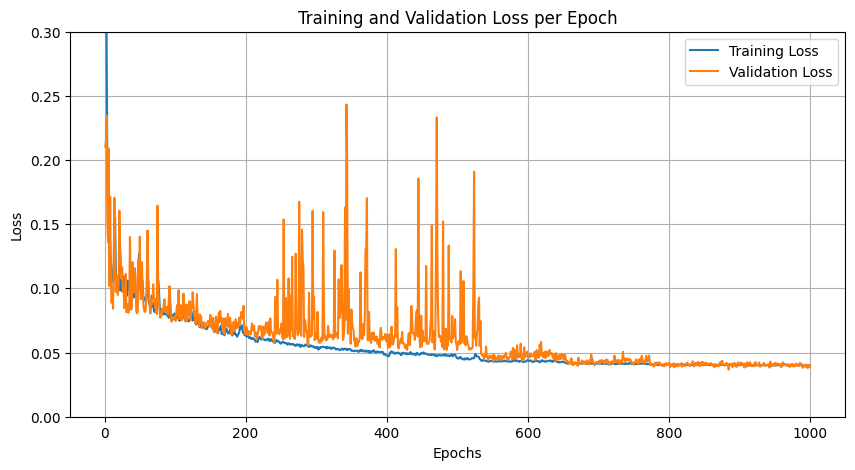

In [ ]:
epochs = range(1, len(train_losses) + 1)
subset = 0
plt.figure(figsize=(10, 5))
plt.plot(epochs[subset::], train_losses[subset::], label='Training Loss')
plt.plot(epochs[subset::], val_losses[subset::], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss per Epoch')
plt.ylim(0, 0.3)
plt.legend()
plt.grid(True)
plt.show()